This notebook assumes you are using sims_maf version >= 1.1, and have 'setup sims_maf' in your shell. 

This notebook demonstrates the basic use of stackers. You can also look at the "Dithers" notebook for more examples, specifically pertaining to dithering. 

Stackers allow the creation of 'virtual' columns to extend the opsim database. These columns are created on-the-fly, using the algorithms in the Stackers classes and cease to exist after the data queried by MAF leaves memory. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

MAF provides a set of stock Stackers, and more are available with the sims_maf_contrib package. You can see the list of registered stackers like this:

In [2]:
stackers.BaseStacker.list(doc=True)

----  EclipticStacker  ----

    Stack on the ecliptic coordinates of each pointing.  Optionally
    subtract off the sun's ecliptic longitude and wrap.
    
 Columns added to SimData:  eclipLat,eclipLon
 Default columns required:  expMJD,fieldRA,fieldDec
----  FilterColorStacker  ----

    Translate filters ('u', 'g', 'r' ..) into RGB tuples.
    
 Columns added to SimData:  rRGB,gRGB,bRGB
 Default columns required:  filter
----  GalacticStacker  ----

    Stack on the galactic coordinates of each pointing.
    
 Columns added to SimData:  gall,galb
 Default columns required:  fieldRA,fieldDec
----  HourAngleStacker  ----

    Add the Hour Angle for each observation.
    
 Columns added to SimData:  HA
 Default columns required:  lst,fieldRA
----  NEODistStacker  ----

    For each observation, find the max distance to a ~144 km NEO,
    also stack on the x,y position of the object.
    
 Columns added to SimData:  MaxGeoDist,NEOHelioX,NEOHelioY
 Default columns required:  solarElong,

---
Let's look at how you might use a simple stacker to calculate the mean of the Hour Angle visited each night. By default Opsim does not provide the Hour Angle, but you can see above that we provide a stacker (HourAngleStacker) to calculate it automatically if requested. 

To use simple stackers that do not require configuration (such as the HourAngleStacker), simply reference the column name which the stacker adds to the opsim data ('simdata').

In [3]:
metric = metrics.MeanMetric(col='HA')
slicer = slicers.OneDSlicer(sliceColName='night', binsize=1)
sqlconstraint = 'night<100'
runName = 'enigma_1189'
mB = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=runName)

In [4]:
opsdb = db.OpsimDatabase(runName+'_sqlite.db')
outDir = 'stackers_test'
resultsDb = db.ResultsDb(outDir=outDir)

We have not set up or referenced the stacker, except by the column name, but when we get the data from the database (done during the 'runAll' step), we can see that the stacker has been called and the virtual column added to the simdata results.

In [5]:
bgroup = metricBundles.MetricBundleGroup({'ha':mB}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
print bgroup.simData.dtype.names

Querying database with constraint night<100
Found 76940 visits
Running:  ['ha']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
('obsHistID', 'lst', 'fieldRA', 'night', 'HA')


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression 'night<100' should be explicitly declared as text('night<100') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


Plotting.
Plotting complete.


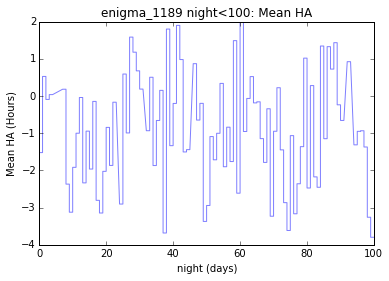

In [6]:
bgroup.plotAll(closefigs=False)

Now let's use a stacker to try out some different dithering options.  Rather than the standard fieldRA and fieldDec columns, we'll add columns that are slightly offset.

In [7]:
slicer = slicers.HealpixSlicer(nside=64, lonCol='nightlyRandomRADither', latCol='nightlyRandomDecDither')
sqlconstraint = 'filter="r" and night<400'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
metric = metrics.CountMetric(col='night')

We could use the stacker in its default configuration, but we want to change it so that the maxDither is much smaller. To do this, we must instantiate the stacker and configure it ourselves, then pass this to the metricBundle.

In [9]:
maxDither = 0.1
stackerList = [stackers.NightlyRandomDitherStacker(maxDither=maxDither)]

In [10]:
plotDict={'colorMax':50, 'xlabel':'Number of Visits', 'label':'max dither = %.2f' % maxDither}
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=runName, 
                                    stackerList=stackerList, plotDict=plotDict)
bgroup = metricBundles.MetricBundleGroup({'dither':bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)

In [11]:
bgroup.runAll()
bgroup.plotAll()

Querying database with constraint filter="r" and night<400
Found 46128 visits
Running:  ['dither']
Completed metric generation.

/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression 'filter="r" and night<400' should be explicitly declared as text('filter="r" and night<400') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})
Optimal bin calculation tried to make 558 bins, returning 200



Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 14.2388  dipole: lon: 56.6765, lat: -76.7455, amp: 7.66088
Plotting complete.


In [12]:
# Update the stacker to use a larger max dither and re-run the bundle
maxDither = 1.75
plotDict2 = {'colorMax':50, 'xlabel':'Number of Visits', 'label':'max dither = %.2f' % maxDither}
stackerList = [stackers.NightlyRandomDitherStacker(maxDither=maxDither)]
bundle2 = metricBundles.MetricBundle(metric, slicer, sqlconstraint, stackerList=stackerList, plotDict=plotDict2)
bgroup2 = metricBundles.MetricBundleGroup({'dither_large':bundle2}, opsdb, outDir=outDir, resultsDb=resultsDb)

In [13]:
bgroup2.runAll()
bgroup2.plotAll()

Querying database with constraint filter="r" and night<400
Found 46128 visits
Running:  ['dither_large']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 13.7382  dipole: lon: 61.6295, lat: -76.7714, amp: 8.51741
Plotting complete.


Optimal bin calculation tried to make 630 bins, returning 200


Now we can combine the results on a single plot if we want to more easily compare them.

monopole: 14.2388  dipole: lon: 56.6765, lat: -76.7455, amp: 7.66088
monopole: 13.7382  dipole: lon: 61.6295, lat: -76.7714, amp: 8.51741


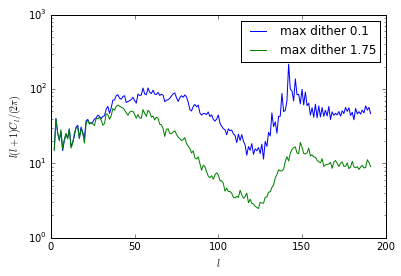

In [14]:
from lsst.sims.maf.plots import HealpixPowerSpectrum
fig = plt.figure(1)
plotter = HealpixPowerSpectrum()
plotter(bundle.metricValues, slicer, {'label':'max dither 0.1'}, fignum=1)
plotter(bundle2.metricValues, slicer, {'label':'max dither 1.75'}, fignum=1)
plt.legend()